In [62]:
# import tarfile

# for i in range(1,4):
#     with tarfile.open(f'part{i}.tar.gz', 'r:gz') as tar:
#         tar.extractall(path='./dataset/') 


In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset,Dataset
import os
from PIL import Image
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter

In [64]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
])

In [65]:
# age_class = []
# gender = []
# ethinicity = []
# images =[]

# folders = os.listdir("./dataset")

# for folder in folders:
#     for image in os.listdir(os.path.join("./dataset",folder)):
#         data = image.split("_")
#         if(len(data)==4 and ('' not in data)):        
#             image = Image.open(f"./dataset/{folder}/{image}").convert('RGB')  
#             tensor = transform(image)
#             images.append(tensor)
#             age,gen,eth = data[:-1]
#             age_class.append(int(age)//5)
#             gender.append(int(gen))
#             ethinicity.append(int(eth))

# print(set(age_class))
# print(set(gender))
# print(set(ethinicity))

In [66]:
z_dim = 100
epochs = 50
lr= 2e-4
img_channels = 3
img_height = 64
img_width = 64
batch_size = 64
conditional_length = 31
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
# class CustomDataset(Dataset):
#     def __init__(self, images, labels):
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         return self.images[idx], self.labels[idx]

# labels = torch.tensor(list(zip(age_class, gender, ethinicity)))

# dataset = CustomDataset(images=torch.stack(images), labels=labels)

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for batch in dataloader:
#     image_batch, label_batch = batch
#     print("Image batch shape:", image_batch.shape)  
#     print("Label batch shape:", label_batch.shape)  
#     break

In [68]:
# batches = []
# for batch_idx, (image, label) in enumerate(dataloader):
#     batches.append((image, label))

# # Save to a file
# torch.save(batches, 'batches.pth')

# # Load the batches later
# loaded_batches = torch.load('batches.pth')

In [69]:
loaded_batches = torch.load('batches.pth')
for batch in loaded_batches:
    image_batch, label_batch = batch
    print("Image batch shape:", image_batch.shape)  
    print("Label batch shape:", label_batch.shape)  
    break

C:\Users\LEGION\AppData\Local\Temp\ipykernel_23216\2368217014.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_batches = torch.load('batches.pth')


Image batch shape: torch.Size([64, 3, 64, 64])
Label batch shape: torch.Size([64, 3])


In [70]:
print(len(loaded_batches))

377


In [71]:
class Generator(nn.Module):
    def __init__(self, z_dim , conditional_length):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim + conditional_length,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024,img_height*img_width*img_channels),
            nn.Tanh()
        )
    
    def forward(self,noise,labels):
        x = torch.cat([noise,labels],dim=1)
        img = self.gen(x)
        return img.view(labels.size(0),img_channels,img_height,img_width)

In [72]:
class Discriminator(nn.Module):
    def __init__(self,img_channels,img_height,img_width,conditional_length):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels*img_height*img_width +conditional_length , 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128,1),
            nn.Sigmoid()
        )
    
    def forward(self,images,labels):
        # Flatten the images: (batch_size, img_channels, img_height, img_width) -> (batch_size, img_channels*img_height*img_width)
        images = images.view(images.size(0), -1)
        labels = labels.view(labels.size(0), -1)
        x = torch.cat([images, labels], dim=1)
        x = self.disc(x)
        return x


In [73]:
generator = Generator(z_dim=z_dim,
                      conditional_length=conditional_length
                      ).to(device)

discriminator = Discriminator(img_channels=img_channels,
                              img_height=img_height,
                              img_width=img_width,
                              conditional_length=conditional_length).to(device)

In [75]:
optim_gen = optim.Adam(params=generator.parameters(),lr=lr,  betas=(0.5,0.999))
optim_disc = optim.Adam(params=discriminator.parameters(),lr=lr,  betas=(0.5,0.999))
criterion = nn.BCELoss()

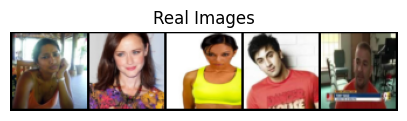

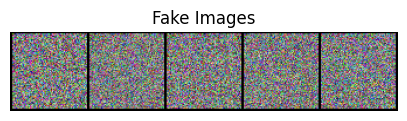

Epoch [1/50] | D Loss: 0.361610472202301 | G Loss: 1.4902671575546265


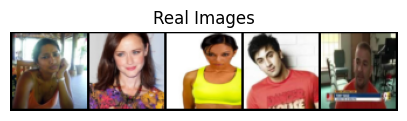

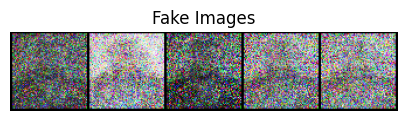

Epoch [2/50] | D Loss: 0.13102951645851135 | G Loss: 2.398808002471924


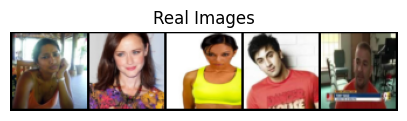

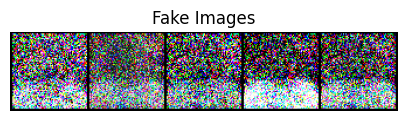

Epoch [3/50] | D Loss: 0.04416554793715477 | G Loss: 3.113487720489502


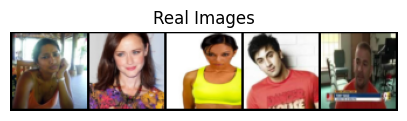

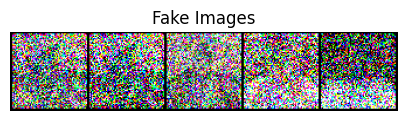

Epoch [4/50] | D Loss: 0.04045160114765167 | G Loss: 3.2756659984588623


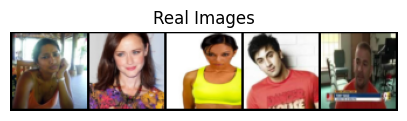

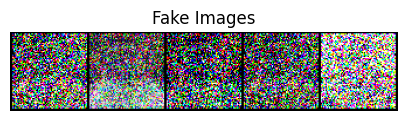

Epoch [5/50] | D Loss: 0.03142167255282402 | G Loss: 3.3744685649871826


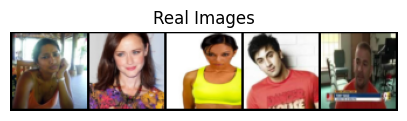

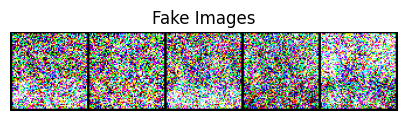

Epoch [6/50] | D Loss: 0.01916845142841339 | G Loss: 3.968953847885132


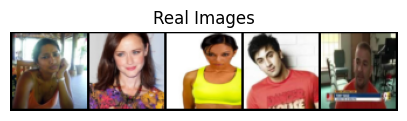

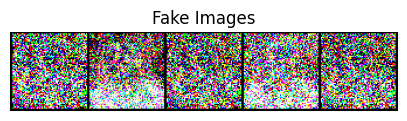

Epoch [7/50] | D Loss: 0.016219716519117355 | G Loss: 4.253440856933594


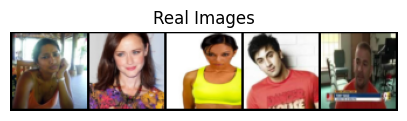

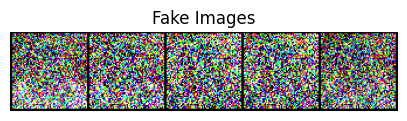

Epoch [8/50] | D Loss: 0.009343892335891724 | G Loss: 4.789700508117676


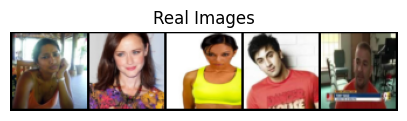

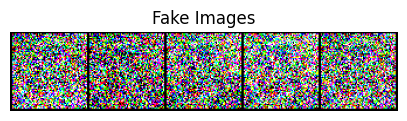

In [ ]:
import matplotlib.pyplot as plt

for epoch in range(epochs):
    for batch_idx, batch in enumerate(loaded_batches):
        if batch_idx < len(loaded_batches) - 1:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            noise = torch.randn(size=(batch_size, z_dim)).to(device)

            fake_labels = torch.zeros(size=(batch_size, 1)).to(device)
            real_labels = torch.ones(size=(batch_size, 1)).to(device)

            age_class_labels = labels[:, 0].long()
            gender_labels = labels[:, 1].long()
            ethnicity_labels = labels[:, 2].long()

            # Initialize the one-hot encoding tensor for the labels (size: batch_size x total_classes)
            labels_one_hot = torch.zeros((labels.size(0), 31)).to(device)

            # Fill in the one-hot labels:
            labels_one_hot[torch.arange(labels.size(0)), 24] = 1
            labels_one_hot[torch.arange(labels.size(0)), gender_labels + 24] = 1
            labels_one_hot[torch.arange(labels.size(0)), ethnicity_labels + 26] = 1

            labels = labels_one_hot.to(device)
            fake_images = generator(noise, labels)

            real_lossD = criterion(discriminator(images, labels), real_labels)
            fake_lossD = criterion(discriminator(fake_images.detach(), labels), fake_labels)
            lossD = (real_lossD + fake_lossD) / 2

            optim_disc.zero_grad()
            lossD.backward()
            optim_disc.step()

            lossG = criterion(discriminator(fake_images, labels), real_labels)
            optim_gen.zero_grad()
            lossG.backward()
            optim_gen.step()

            if batch_idx == 0:
                # Generate grid of real and fake images
                real_images_grid = vutils.make_grid(images[:5], nrow=5, normalize=True)
                fake_images_grid = vutils.make_grid(fake_images[:5], nrow=5, normalize=True)

                # Plot real images
                plt.figure(figsize=(5,5))
                plt.imshow(real_images_grid.permute(1, 2, 0).cpu().numpy())
                plt.title('Real Images')
                plt.axis('off')
                plt.show()

                # Plot fake images
                plt.figure(figsize=(5, 5))
                plt.imshow(fake_images_grid.permute(1, 2, 0).cpu().numpy())
                plt.title('Fake Images')
                plt.axis('off')
                plt.show()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {lossD.item()} | G Loss: {lossG.item()}")
